In [198]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np
from sklearn.utils.class_weight import compute_class_weight  # ✅ 클래스 가중치 계산용

In [200]:
# 데이터셋 인스턴스 생성

data = pd.read_csv("C:\\Users\\LG\\Downloads\\BP_data.csv")  # CSV 파일 경로

In [238]:
data.columns

print("클래스 분포:", np.bincount(y.astype(int)))

클래스 분포: [1013  987]


In [204]:
columns=['Patient_Number', 'Blood_Pressure_Abnormality', 'Level_of_Hemoglobin',
       'Genetic_Pedigree_Coefficient', 'Age', 'BMI', 'Sex', 'Pregnancy',
       'Smoking', 'Physical_activity', 'salt_content_in_the_diet',
       'alcohol_consumption_per_day', 'Level_of_Stress',
       'Chronic_kidney_disease', 'Adrenal_and_thyroid_disorders']

In [206]:
# 데이터와 타겟 분리
X = data.drop(['Patient_Number', 'Blood_Pressure_Abnormality'], axis=1).values
y = data['Blood_Pressure_Abnormality'].values

In [208]:
# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [210]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, 

((1600, 13), (400, 13), (1600,), (400,))

In [212]:
import torch

# NumPy 배열을 Tensor로 변환 후 전처리
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [214]:
import torch

# NumPy 배열을 PyTorch Tensor로 변환하고 float32로 캐스팅
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

In [216]:
# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [218]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1600, 13]),
 torch.Size([400, 13]),
 torch.Size([1600, 1]),
 torch.Size([400, 1]))

In [220]:
# 모델 정의
class BPNet(nn.Module):
    def __init__(self, input_dim):
        super(BPNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # 출력층: sigmoid 없음 (BCEWithLogitsLoss 사용 예정)
        )

    def forward(self, x):
        return self.net(x)
# 모델 초기화
model = BPNet(input_dim=X_train.shape[1])

In [222]:
# 학습 및 평가 저장용 리스트
train_losses = []
test_accuracies = []

from sklearn.utils.class_weight import compute_class_weight
import torch

# 정수형 클래스 벡터로 변환
y_np = y.astype(int)  # ← y = data['Blood_Pressure_Abnormality'].values

# 클래스 가중치 계산
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_np), y=y_np)

# torch 텐서로 변환
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# BCEWithLogitsLoss는 양성 클래스(1)에 대한 가중치만 받음
pos_weight = class_weights[1]  # 🔧 이것이 손실 함수에 들어갈 변수

In [224]:
# ✅ 클래스 불균형 반영한 손실 함수 적용 (여기!)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [226]:
# 학습 루프
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_dataloader))

   # 테스트 정확도 계산
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")

Epoch 1/20, Loss: nan, Accuracy: 52.00%
Epoch 2/20, Loss: nan, Accuracy: 52.00%
Epoch 3/20, Loss: nan, Accuracy: 52.00%
Epoch 4/20, Loss: nan, Accuracy: 52.00%
Epoch 5/20, Loss: nan, Accuracy: 52.00%
Epoch 6/20, Loss: nan, Accuracy: 52.00%
Epoch 7/20, Loss: nan, Accuracy: 52.00%
Epoch 8/20, Loss: nan, Accuracy: 52.00%
Epoch 9/20, Loss: nan, Accuracy: 52.00%
Epoch 10/20, Loss: nan, Accuracy: 52.00%
Epoch 11/20, Loss: nan, Accuracy: 52.00%
Epoch 12/20, Loss: nan, Accuracy: 52.00%
Epoch 13/20, Loss: nan, Accuracy: 52.00%
Epoch 14/20, Loss: nan, Accuracy: 52.00%
Epoch 15/20, Loss: nan, Accuracy: 52.00%
Epoch 16/20, Loss: nan, Accuracy: 52.00%
Epoch 17/20, Loss: nan, Accuracy: 52.00%
Epoch 18/20, Loss: nan, Accuracy: 52.00%
Epoch 19/20, Loss: nan, Accuracy: 52.00%
Epoch 20/20, Loss: nan, Accuracy: 52.00%
Training complete.


In [228]:
from sklearn.metrics import precision_score

In [230]:
# Evaluation
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        predicted = (outputs >= 0.5).float()  # 🔧 이진 분류 방식에 맞는 예측
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

y_true = np.array(all_labels)
y_pred = np.array(all_predictions)

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate metrics
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

# Calculate specificity for each class
specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')

Confusion Matrix:
[[208   0]
 [192   0]]
F1 Score: 0.36
Precision: 0.27
Recall: 0.52
Specificity: 0.50


C:\Users\LG\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


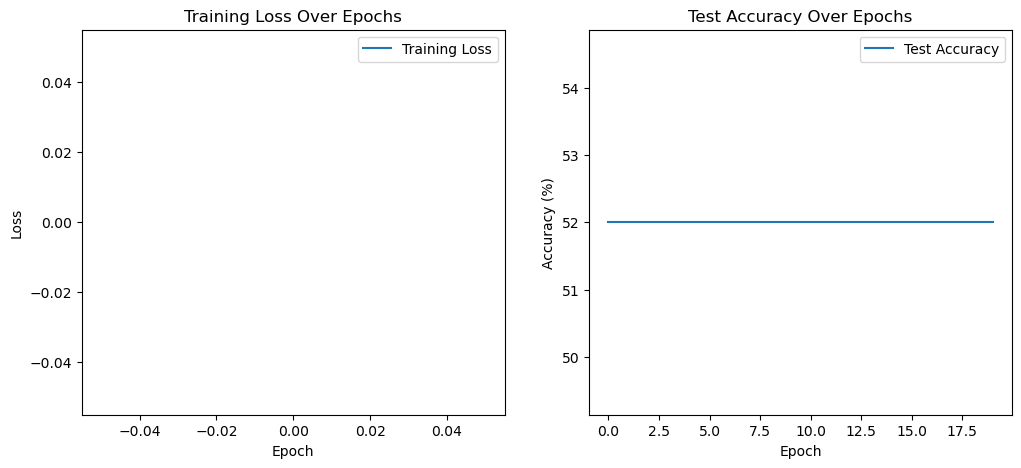

In [232]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()